# 第五章 描述和生成游戏 🖍️

##  一、背景

本章，我们将通过结合图片文字描述应用程序（第二章）以及文字图片生成应用程序（第四章）来构建一个简单的游戏，即先对图像进行描述，然后通过模型产生的描述再生成一张图片。

## 二、环境配置

加载 HF API 和相关的 Python API。

In [ ]:
import os
import io
from IPython.display import Image, display, HTML
from PIL import Image
import base64 

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
hf_api_key = os.environ['HF_API_KEY']

## 三、核心 API 调用

In [ ]:
import requests, json

# 我们将会通过这个函数既调用图像描述模型，也调用图像生成模型
def get_completion(inputs, parameters=None, ENDPOINT_URL=""):
    headers = {
      "Authorization": f"Bearer {hf_api_key}",
      "Content-Type": "application/json"
    }   
    data = { "inputs": inputs }
    if parameters is not None:
        data.update({"parameters": parameters})
    response = requests.request("POST",
                                ENDPOINT_URL,
                                headers=headers,
                                data=json.dumps(data))
    return json.loads(response.content.decode("utf-8"))

In [ ]:
#图像生成模型 API
TTI_ENDPOINT = os.environ['HF_API_TTI_BASE']
#图像描述模型 API
ITT_ENDPOINT = os.environ['HF_API_ITT_BASE']

## 四、通过 `gr.Blocks()` 构建简单的游戏

将前几课我们用到的图片到base64、base64到图片、图片描述、图片生成的函数整理如下。

In [ ]:
#Bringing the functions from lessons 3 and 4!
# PIL 图像转换为 base64 字符串
def image_to_base64_str(pil_image):
    byte_arr = io.BytesIO()
    pil_image.save(byte_arr, format='PNG')
    byte_arr = byte_arr.getvalue()
    return str(base64.b64encode(byte_arr).decode('utf-8'))

# base64 字符串转换为 PIL 图像
def base64_to_pil(img_base64):
    base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(base64_decoded)
    pil_image = Image.open(byte_stream)
    return pil_image

# 图像描述
def captioner(image):
    base64_image = image_to_base64_str(image)
    result = get_completion(base64_image, None, ITT_ENDPOINT)
    return result[0]['generated_text']

# 图像生成
def generate(prompt):
    output = get_completion(prompt, None, TTI_ENDPOINT)
    result_image = base64_to_pil(output)
    return result_image

### 4.1 第一步：图片描述

我们先用 Gradio 复现图像描述的 GUI。

In [ ]:
import gradio as gr 
with gr.Blocks() as demo:
    gr.Markdown("# 描述和生成游戏")
    image_upload = gr.Image(label="你的第一张图片",type="pil")
    btn_caption = gr.Button("生成描述")
    caption = gr.Textbox(label="生成的描述")
    
    btn_caption.click(fn=captioner, inputs=[image_upload], outputs=[caption])

gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT1']))

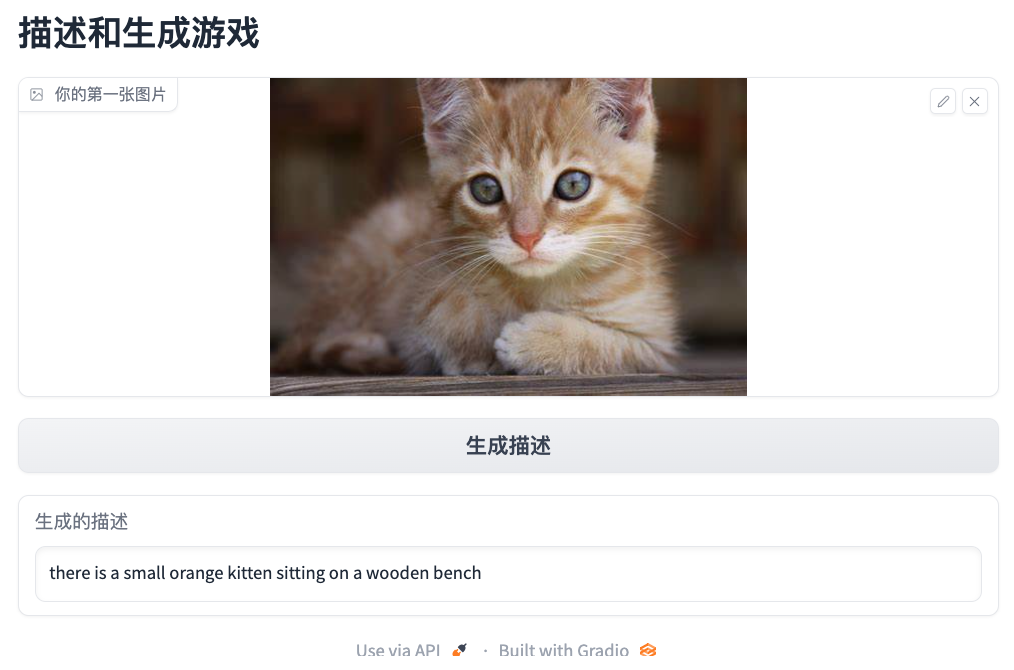

### 4.2 第二步：添加图像生成

然后，我们将图像生成功能加入到之前制作的图像描述 GUI 中。

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# 描述和生成游戏 🖍️")
    image_upload = gr.Image(label="你的第一张图片",type="pil")
    btn_caption = gr.Button("生成描述")
    caption = gr.Textbox(label="生成的描述")
    btn_image = gr.Button("生成图片")
    image_output = gr.Image(label="生成的图片")
    btn_caption.click(fn=captioner, inputs=[image_upload], outputs=[caption])
    btn_image.click(fn=generate, inputs=[caption], outputs=[image_output])

gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT2']))

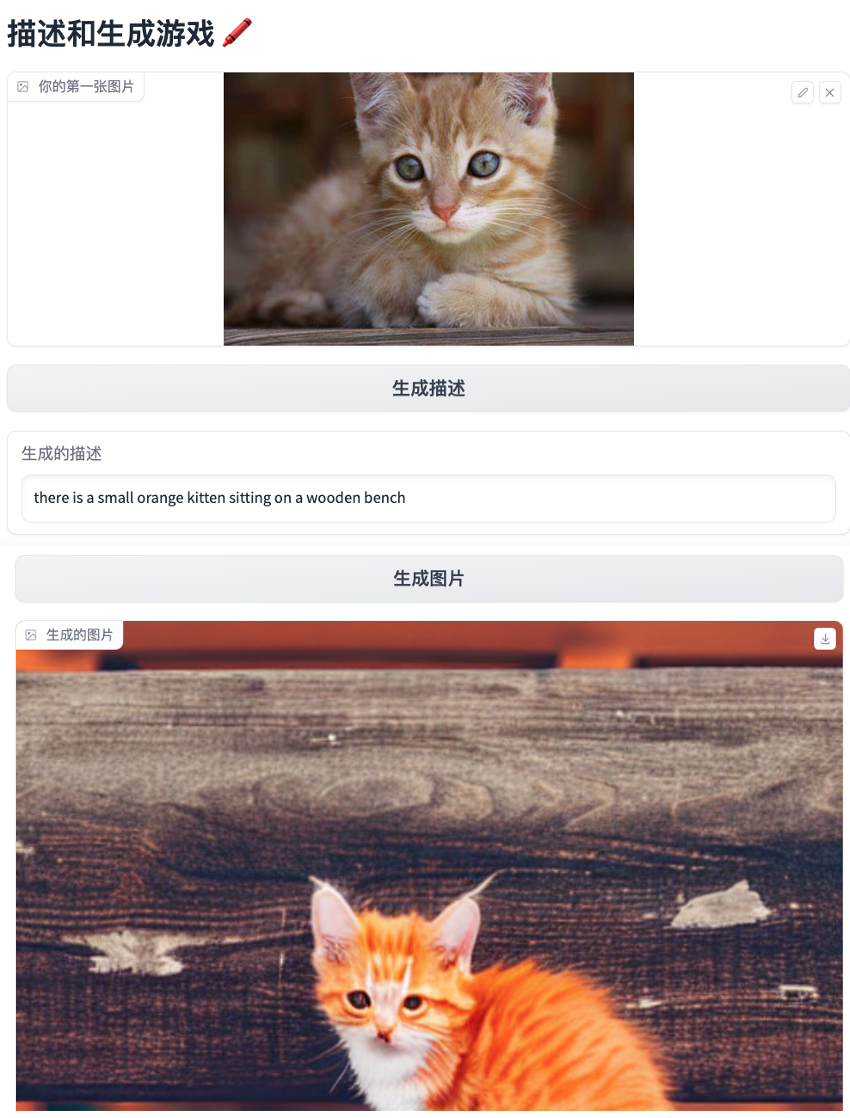

### 4.3 合并前两步：直接输入图片得到输出图片

上面我们制作的 GUI 需要分别点击“描述”和“生成”两个按键，现在我们将两个按键统一为一个“描述和生成”按键。这样，我们就可以一步得到重新生成的图片。

In [ ]:
def caption_and_generate(image):
    caption = captioner(image)
    image = generate(caption)
    return [caption, image]

with gr.Blocks() as demo:
    gr.Markdown("# Describe-and-Generate game 🖍️")
    image_upload = gr.Image(label="Your first image",type="pil")
    btn_all = gr.Button("Caption and generate")
    caption = gr.Textbox(label="Generated caption")
    image_output = gr.Image(label="Generated Image")

    btn_all.click(fn=caption_and_generate, inputs=[image_upload], outputs=[caption, image_output])

gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT3']))

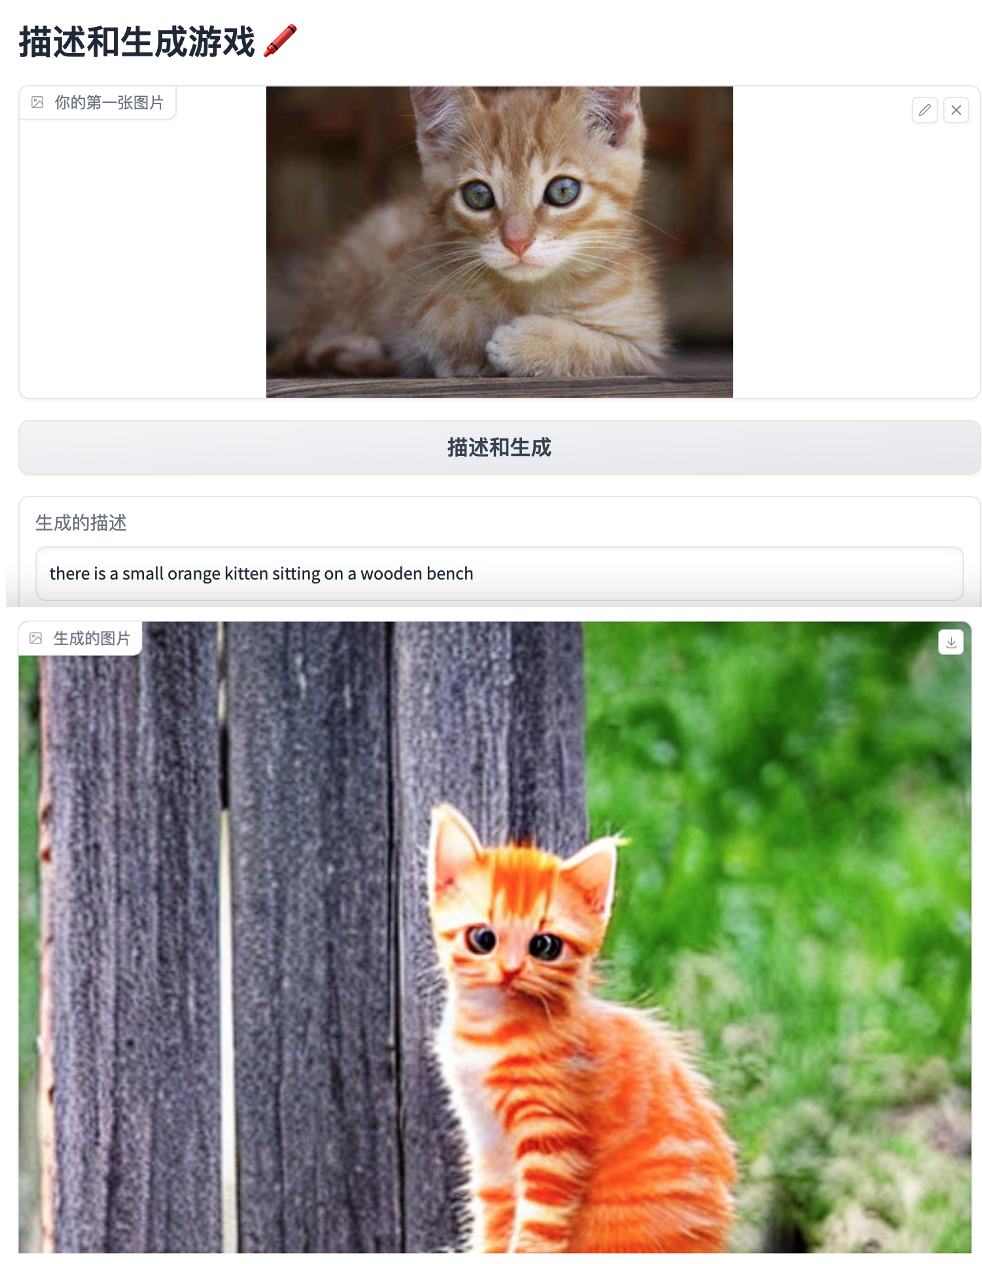

In [ ]:
gr.close_all()